## SETUP (PERSIAPAN)

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pandas as pd
from pandas import Series, date_range, DataFrame

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### DATASET

In [2]:
df = pd.read_csv('PasutRapi.csv', sep=';')

In [3]:
df.head()

,Time (UTC),WaterLevel(m)
0,09/08/2024 00:00,"1,775"
1,09/08/2024 00:01,"1,746"
2,09/08/2024 00:02,"1,754"
3,09/08/2024 00:03,"1,77"
4,09/08/2024 00:04,"1,762"


In [4]:
df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'], format="%d/%m/%Y %H:%M")
df['WaterLevel(m)'] = pd.to_numeric(df['WaterLevel(m)'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Time (UTC)     1048575 non-null  datetime64[ns]
 1   WaterLevel(m)  5600 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.0 MB


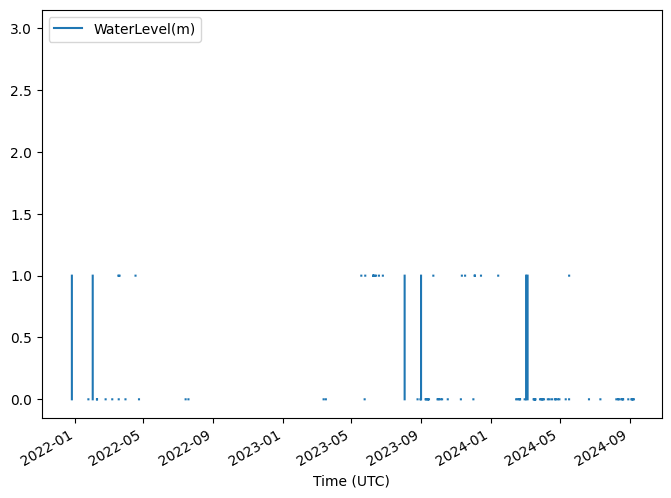

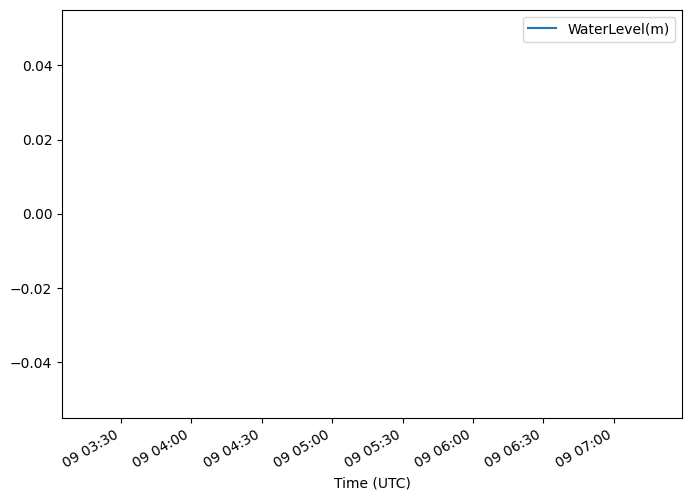

In [5]:
plot_cols = ['WaterLevel(m)']
plot_features = df[plot_cols]
plot_features.index = df['Time (UTC)']
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = df['Time (UTC)'][:480]
_ = plot_features.plot(subplots=True)

### INSPECT AND CLEANUP

In [6]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Time (UTC),1048575,2023-07-13 13:35:26.198525696,2021-12-23 00:00:00,2023-03-06 20:07:30,2023-09-05 11:55:00,2024-03-07 19:45:30,2024-09-08 00:00:00,NaN
WaterLevel(m),5600.0,0.20375,0.0,0.0,0.0,0.0,3.0,0.426092


In [7]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Time (UTC),1048575,2023-07-13 13:35:26.198525696,2021-12-23 00:00:00,2023-03-06 20:07:30,2023-09-05 11:55:00,2024-03-07 19:45:30,2024-09-08 00:00:00,NaN
WaterLevel(m),5600.0,0.20375,0.0,0.0,0.0,0.0,3.0,0.426092


### FEATURE ENGINEERING

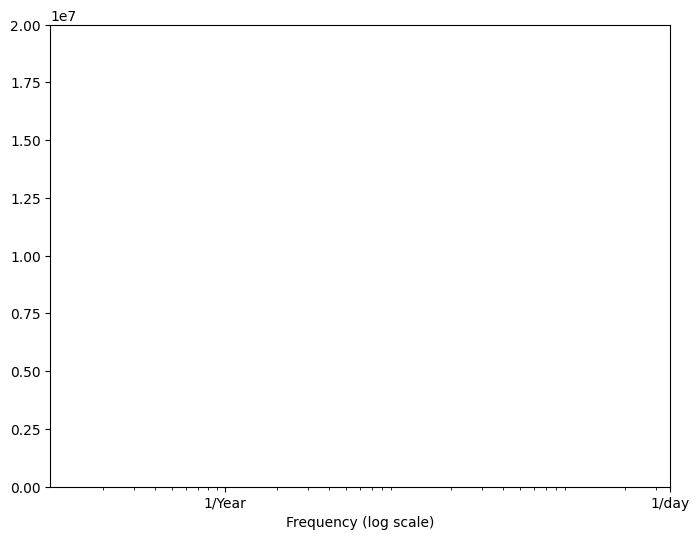

In [8]:
fft = tf.signal.rfft(df['WaterLevel(m)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['WaterLevel(m)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 20000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### SPLIT THE DATA

In [9]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch
from tqdm import tqdm

# 定义读取时间序列并进行MMS归一化的dataReader
class mydataReader:
    def __init__(self,filename) -> None:
        data_csv = pd.read_csv(filename, usecols=['Time (UTC)','WaterLevel(m)'],
        index_col='Time (UTC)',parse_dates=['Time (UTC)'])
        # ##############################################################
        # Tips:
        # 数据预处理(归一化有利于梯度下降)-MMS标准化
        # 如果不进行归一化，那么由于特征向量中不同特征的取值相差较大，
        # 会导致目标函数变“扁”。这样在进行梯度下降的时候，
        # 梯度的方向就会偏离最小值的方向，走很多弯路，即训练时间过长。
        # ##############################################################
        data_csv = data_csv.dropna()
        max_value = data_csv["WaterLevel(m)"].max()
        min_value = data_csv["WaterLevel(m)"].min()
        scalar = max_value - min_value
        with open("scalar.txt",mode='w+',encoding='utf-8') as f:
            f.write("max_value = {0} \nmin_value = {1} \nscalar = {2}".format(max_value,min_value,scalar))
        f.close()

        data_csv["WaterLevel(m)"] = data_csv["WaterLevel(m)"].map(lambda x: (x-min_value)/scalar)

        self.data_csv = data_csv

        # 改变值类型
        dataset = data_csv.values
        self.dataset = dataset.astype('float32')

    def split(self,lookback,trainSet_ratio = 0.7,valSet_ratio = 0.1):
        # 数据集创建
        dataX, dataY = [], []
        # print(self.dataset.shape) (19316, 1) data_csv.values会多出一个维度
        for i in tqdm(range(len(self.dataset) - lookback)):
            a = self.dataset[i:(i + lookback)]
            dataX.append(a)
            dataY.append(self.dataset[i + lookback])
        data_X,data_Y = np.array(dataX), np.array(dataY)
        # 去掉那个多的维度
        data_X = data_X.squeeze()

        # print(data_X.shape) (19306, 10)
        # print(data_Y.shape) (19306, 1)

        # 数据划分
        train_size = int(len(data_X) * trainSet_ratio)
        val_size = int(len(data_X) * valSet_ratio)
        test_size = len(data_X) - train_size - val_size

        train_X = data_X[:train_size]
        train_Y = data_Y[:train_size]
        val_X = data_X[train_size:train_size+val_size]
        val_Y = data_Y[train_size:train_size+val_size]
        test_X = data_X[train_size+val_size:]
        test_Y = data_Y[train_size+val_size:]

        print("测试集大小为{}".format(test_size))
        return (train_X,train_Y) , (val_X,val_Y) , (test_X,test_Y)

    def getSeries(self):
        """
        返回原始序列
        """
        return self.data_csv

# 定义一个子类叫 custom_dataset，继承与 Dataset
class custom_dataset(Dataset):
    def __init__(self,data_X,data_Y):
        """
        :parameters:
        data_X: 构造好的X矩阵
        data_Y: 构造好的Y标签
        """
        self.X = torch.tensor(data_X, dtype=torch.float32)
        self.Y = torch.tensor(data_Y, dtype=torch.float32)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return len(self.X)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\Insert Name\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\Insert Name\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\In

In [10]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

# 定义模型
# 简单BiLSTM
class BiLSTM_Reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2, dropout=0.5):
        super(BiLSTM_Reg, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True,
                            bidirectional=True)

        self.fc = nn.Linear(hidden_size * 2, output_size)  # bidirectional

    def forward(self, x):
        out, _ = self.lstm(x)  # (batch_size, seq_len, feature_size)

        out = self.fc(out[:, -1, :])  # 使用隐藏层最后一个time step进行预测

        return out

class CNNBiLSTM(nn.Module):
    def __init__(self,hidden_size,num_layers):
        super(CNNBiLSTM, self).__init__()

        # self.conv_pool = nn.ModuleList([ConvModule(if_pool=False),
        #                                 ConvModule(if_pool=False),
        #                                 ConvModule()])
        self.conv_pool = nn.Sequential(ConvModule())
        self.lstm = BiLSTMModule(hidden_size=hidden_size,num_layers=num_layers)

    def forward(self, x):
        
        x = self.conv_pool(x)  # (batch_size, channel_size=1, seq_len)
            
        out = x.squeeze_().unsqueeze_(2)  # (batch_size, seq_len, feature_size=1)

        out = self.lstm(out)  # (batch_size, seq_len=1, feature_size=1)

        return out

class ConvModule(nn.Module):
    """
    convolution-based options:

    conv-1d:
    (batch_size, channel_size, input_size)  input_size(seq_len)是conv-1d的操作维度
    after conv:
    seq_len' = (input_size - kernel_size + 2 * pad_size) // stride + 1
    (k=3, s=1, p=1) 可以保持输入维度不变
    """

    def __init__(self,
                 c_k=3, c_s=1, c_p=1,  # conv param
                 p_k=3, p_s=1, p_p=1,  # pool param
                 if_pool: bool = True):
        super(ConvModule, self).__init__()

        self.conv = nn.Conv1d(in_channels=1,
                              out_channels=1,
                              kernel_size=c_k,
                              stride=c_s,
                              padding=c_p)

        self.if_pool = if_pool
        if if_pool:
            self.pool = nn.MaxPool1d(kernel_size=p_k,
                                     stride=p_s,
                                     padding=p_p)

    def forward(self, x):
        out = self.conv(x)

        if self.if_pool:
            out = self.pool(out)

        return out

class BiLSTMModule(nn.Module):
    def __init__(self, hidden_size=1, num_layers=2, dropout=0.5):
        super(BiLSTMModule, self).__init__()
        # 在这里你可以修改成GRU单元
        self.lstm = nn.LSTM(input_size=1,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True,
                            bidirectional=True)

        self.fc = nn.Linear(hidden_size * 2, 1)  # bidirectional

    def forward(self, x):
        out, _ = self.lstm(x)  # (batch_size, seq_len, feature_size)

        out = self.fc(out[:, -1, :])  # 使用隐藏层最后一个time step进行预测

        return out

# TCN模块
# 这个函数是用来修剪卷积之后的数据的尺寸，让其与输入数据尺寸相同。
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# 这个就是TCN的基本模块，包含8个部分，两个（卷积+修剪+relu+dropout）
# 里面提到的downsample就是下采样，其实就是实现残差链接的部分。不理解的可以无视这个
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

# TCN主网络
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [ ]:
from statistics import mean, mode
from tqdm import tqdm
from numpy import sqrt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

def RNNevaluate(model, loader, config, val_mode=False):
    model.eval()

    y = list()
    y_pre = list()
    for idx, (X, Y) in tqdm(enumerate(loader)):
        # batch first,(batch,seq_len,input_size),所以增加第三个维度.因为单序列,所以inputsize维度为1
        X = X.unsqueeze(2).to(config.device)
        Y = Y.to(config.device)
        
        y_pre += model(X).cpu().squeeze().tolist()
        y += Y.cpu().squeeze().tolist()

    if val_mode:
        valmeanSquaredError = mean_squared_error(y_true=y, y_pred=y_pre)
        return valmeanSquaredError
    else:
        r2Score = r2_score(y_true=y, y_pred=y_pre)
        meanSquaredError = mean_squared_error(y_true=y, y_pred=y_pre)
        meanAbsoluteError = mean_absolute_error(y_true=y, y_pred=y_pre)
        print("r2Score: ", r2Score)
        print("meanSquaredError: ", meanSquaredError)
        print('RMSE: ',sqrt(meanSquaredError))
        print("meanAbsoluteError: ", meanAbsoluteError)

        # 画出实际结果和预测的结果
        import matplotlib.pyplot as plt
        plt.plot(range(len(y[:1000])),y_pre[:1000],color = 'red',linewidth = 1.5,linestyle = '-.',label='prediction')
        plt.plot(range(len(y[:1000])),y[:1000],color = 'blue',linewidth = 1.5,linestyle = '-', label='real')
        plt.legend(loc='best')

        return y_pre,y

def CNNBiLstm_evaluate(model, loader, config, val_mode=False):
    model.eval()

    y = list()
    y_pre = list()
    for idx, (X, Y) in tqdm(enumerate(loader)):
        # Conv1d接受的数据输入是(batch_size有, channel_size=1, seq_len有),故增加一个通道数，单序列通道数为1，第2维
        X = X.unsqueeze(-2).to(config.device)
        Y = Y.to(config.device)
        
        y_pre += model(X).cpu().squeeze().tolist()
        y += Y.cpu().squeeze().tolist()

    if val_mode:
        valmeanSquaredError = mean_squared_error(y_true=y, y_pred=y_pre)
        return valmeanSquaredError
    else:
        r2Score = r2_score(y_true=y, y_pred=y_pre)
        meanSquaredError = mean_squared_error(y_true=y, y_pred=y_pre)
        meanAbsoluteError = mean_absolute_error(y_true=y, y_pred=y_pre)
        print("r2Score: ", r2Score)
        print("meanSquaredError: ", meanSquaredError)
        print('RMSE: ',sqrt(meanSquaredError))
        print("meanAbsoluteError: ", meanAbsoluteError)

        # 画出实际结果和预测的结果
        import matplotlib.pyplot as plt
        plt.plot(range(len(y[:1000])),y_pre[:1000],color = 'red',linewidth = 1.5,linestyle = '-.',label='prediction')
        plt.plot(range(len(y[:1000])),y[:1000],color = 'blue',linewidth = 1.5,linestyle = '-', label='real')
        plt.legend(loc='best')

        return y_pre,y


def RNNtrain(model, trainloader,valloader,criterion, optimizer, config):
    logfile = open("trainLog.txt",mode='a+',encoding='utf-8')
    for epoch in range(config.epoch_size):
        # 每个epoch开始模型训练模式
        model.train()
        for idx, (X, Y) in enumerate(trainloader):
            # batch first,(batch,seq_len,input_size),所以增加第三个维度.因为单序列,所以inputsize维度为1
            X = X.unsqueeze(2).to(config.device)
            Y = Y.to(config.device)
            
            predict = model(X)
            loss = criterion(predict, Y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if idx % 10 == 0:
                print(f"Epoch: {epoch} batch: {idx} | loss: {loss}")
                
        
        # 一个epoch结束,进行一次验证,并保存相关记录
        valMSE = RNNevaluate(model,loader = valloader,config=config,val_mode=True)
        print(f"Epoch: {epoch} valLoss: {valMSE}")
        logfile.write("Epoch: {0} valLoss: {1} \n".format(epoch,valMSE))
    logfile.write("\n")
    logfile.close()
    return model

def CNNBiLstmtrain(model, trainloader,valloader, criterion, optimizer, config):
    logfile = open("trainLog.txt",mode='a+',encoding='utf-8')
    for epoch in range(config.epoch_size):
        model.train()
        for idx, (X, Y) in enumerate(trainloader):
            # Conv1d接受的数据输入是(batch_size有, channel_size=1, seq_len有),故增加一个通道数，单序列通道数为1，第2维
            X = X.unsqueeze(-2).to(config.device)
            Y = Y.to(config.device)
            
            predict = model(X)
            loss = criterion(predict, Y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if idx % 10 == 0:
                print(f"Epoch: {epoch} batch: {idx} | loss: {loss}")
                
        
        # 一个epoch结束,进行一次验证,并保存相关记录
        valMSE = CNNBiLstm_evaluate(model,loader = valloader,config=config,val_mode=True)
        print(f"Epoch: {epoch} valLoss: {valMSE}")
        logfile.write("Epoch: {0} valLoss: {1} \n".format(epoch,valMSE))

    logfile.write("\n")
    logfile.close()
    return model

In [13]:
import torch

class Config:
    def __init__(self):
        super(Config, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.batch_size = 30
        self.epoch_size = 2
        self.learning_rate = 5e-4
        self.weight_decay = 1e-2
        self.lookback = 10

In [16]:
import torch
from torch.utils.data import DataLoader

if __name__ == '__main__':
    config = Config()

    print("Data loading...")
    # 序列数据
    dataset = mydataReader("PasutRapi.csv")

    # 创建X/Y
    # 划分训练集和测试集，70% 作为训练集,10%作为验证集,20%作为测试集
    (train_X ,train_Y ), (val_X,val_Y), (test_X ,test_Y )= dataset.split(lookback=config.lookback,trainSet_ratio=0.7,valSet_ratio=0.1)

    # 创建Pytorch使用的dataset
    trainSet = custom_dataset(train_X,train_Y)
    valSet = custom_dataset(val_X,val_Y)
    testSet = custom_dataset(test_X,test_Y)

    train_loader = DataLoader(trainSet, batch_size = config.batch_size,
                              shuffle=False, pin_memory=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(valSet, batch_size = config.batch_size,
                              shuffle=False, pin_memory=True, num_workers=0, drop_last=False)
    test_loader = DataLoader(testSet, batch_size = config.batch_size,
                            shuffle=False, pin_memory=True, num_workers=0, drop_last=False)


    print("Model loading...")
    model = CNNBiLSTM(hidden_size=12,num_layers=2).to(config.device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                 lr=config.learning_rate, weight_decay=config.weight_decay)

    print("Training...")
    model = CNNBiLstmtrain(model,
                  trainloader=train_loader,
                  valloader=val_loader,
                  criterion=criterion,
                  optimizer=optimizer,
                  config=config)

    print("Testing...", round(len(testSet)/config.batch_size))
    CNNBiLstm_evaluate(model, test_loader, config)


Data loading...


ValueError: Number of passed names did not match number of header fields in the file